In [1]:
import pandas as pd
import numpy as np

### Download original dataset

# 2. Prepare Dataset for train

In [2]:
df_train = pd.read_csv('train_eng.csv')
df_test = pd.read_csv('test_eng.csv')

df_test['train_val'] = 'test'

In [3]:
#df_train['tarin_val'] = df_train_grouped.apply(lambda x: 'val' if (df_train.EndDate>"2017-06-30") else 'train')
df_train['train_val'] = np.where((df_train.EndDate>"2017-06-30")  & (df_train.LotStatus == 'Завершено лот закупівлі') & (df_train.TenderStatus=='complete'), 'val', 'train')
#def add_cv_column(df):
#    df['EndDate'] = pd.to_datetime(df['EndDate'])
#    temp_df1 = df[df['EndDate'] <= "2017-06-30"].copy()
#    temp_df1['cv_status'] = 'train'
#    temp_df2 = df[df['EndDate'] > "2017-06-30"].copy()
#    temp_df2['cv_status'] = 'cv'
#    return pd.concat([temp_df1, temp_df2]) 
#df_final = add_cv_column(df_train)

In [4]:
df_train['train_val'].value_counts()

train    802876
val      143278
Name: train_val, dtype: int64

In [5]:
df_train.set_index('unique_id', inplace=True)
df_train = df_train[[c for c in df_train.columns if c in df_test.columns]]
df_train_grouped = df_train.groupby(df_train.index).head(1).sort_index()
df_train_grouped['counts'] = df_train.groupby(df_train.index).size().sort_index()

In [6]:
df_train_grouped.columns

Index(['Unnamed: 0', 'CPV2017', 'SumTender', 'Organizer', 'ID', 'IDLOT',
       'StartOfferDate', 'TypeMethod', 'TypeOrginizer', 'LotStatus',
       'TenderStatus', 'OrgRegion', 'DeliveryRegion', 'Tender',
       'StartDateCorrection', 'LotDescr', 'IDOrganizator', 'EndDate',
       'EndOfferDate', 'StepDecreaseLot', 'GuaranteeValueLot', 'train_val',
       'counts'],
      dtype='object')

# 3. Check Validation

In [99]:
train = df_train_grouped[df_train_grouped.train_val=='train']
val = df_train_grouped[df_train_grouped.train_val=='val']

# 3.  Numerical Features

In [8]:
features_numerical = ['GuaranteeValueLot', 'StepDecreaseLot', 'SumTender']

In [13]:
train[features_numerical].head()

GuaranteeValueLot  \
unique_id                                                               
00000b82d15745548d9d5b70c0b439a9_2318185a93a34f...                0.0   
0000431d17fe41fea60d13dfec6bd077_Lot0000431d17f...                0.0   
000045b1b0a840ef85f8589734392c6d_Lot000045b1b0a...                0.0   
000103a836ea45ab8949cd6fbef95a09_Lot000103a836e...                0.0   
000124d130594741ad66425cb14f85a5_Lot000124d1305...                0.0   

                                                    StepDecreaseLot  SumTender  
unique_id                                                                       
00000b82d15745548d9d5b70c0b439a9_2318185a93a34f...           400.00    80000.0  
0000431d17fe41fea60d13dfec6bd077_Lot0000431d17f...           249.97    49993.6  
000045b1b0a840ef85f8589734392c6d_Lot000045b1b0a...           766.22   153244.8  
000103a836ea45ab8949cd6fbef95a09_Lot000103a836e...            41.50     8300.0  
000124d130594741ad66425cb14f85a5_Lot000124d1305...            40.30     8060.0

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
train.boxplot(column="GuaranteeValueLot",        # Column to plot
                 by= "counts",         # Column to split upon
                 figsize= (8,8))        # Figure size

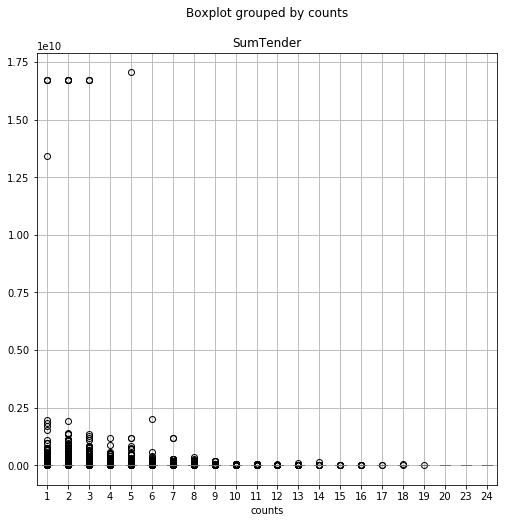

In [23]:
train.boxplot(column="SumTender",        # Column to plot
                 by= "counts",         # Column to split upon
                 figsize= (8,8))        # Figure size

In [29]:
train.plot(kind="scatter",     # Create a scatterplot
              x=features_numerical[0],          # Put carat on the x axis
              y="counts",          # Put price on the y axis
              figsize=(10,10),
              ylim=(0,7))

In [30]:
train.plot(kind="scatter",     # Create a scatterplot
              x=features_numerical[1],          # Put carat on the x axis
              y="counts",          # Put price on the y axis
              figsize=(10,10),
              ylim=(0,7))

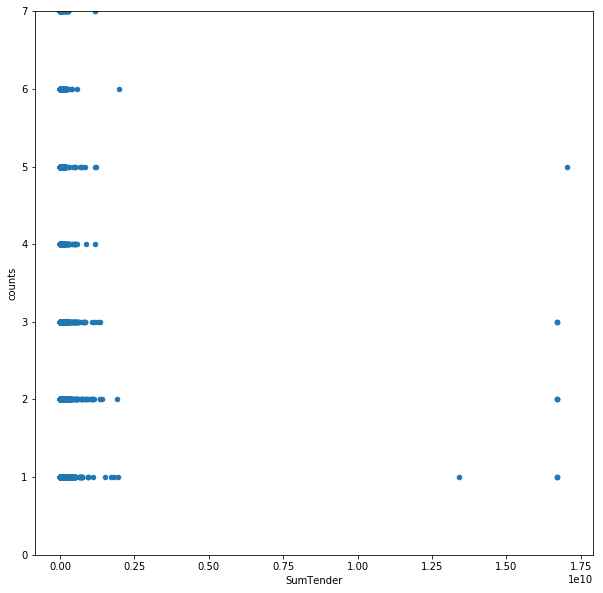

In [31]:
train.plot(kind="scatter",     # Create a scatterplot
              x=features_numerical[2],          # Put carat on the x axis
              y="counts",          # Put price on the y axis
              figsize=(10,10),
              ylim=(0,7))

In [106]:
def boxcox_feature(feature_name, df):
    import scipy.stats as spstats
    feature_np = np.array(train[feature_name])
    feature_np_clean = feature_np[~np.isnan(feature_np)]
    l, opt_lambda = spstats.boxcox(feature_np_clean)
    df[feature_name+'_0'] = spstats.boxcox(
                                        (1+df[feature_name]), 
                                          lmbda=0)
    df[feature_name+'_0'] = df[feature_name+'_0'].fillna(0.0)
    df[feature_name+'_boxcox_lambda_opt'] = spstats.boxcox(
                                            df[feature_name], lmbda = opt_lambda)
    df[feature_name+'_boxcox_lambda_opt'] = df[feature_name+'_boxcox_lambda_opt'].fillna(0.0)
    return df

In [107]:
#just feed df with eng columns
def transfrom_numerical(df):
    features_numerical = ['GuaranteeValueLot', 'StepDecreaseLot', 'SumTender']
    for feature in features_numerical:
        df[feature] = df[feature].apply(pd.to_numeric, errors='coerce')
    df[features_numerical] = df[features_numerical].fillna(0)
    for feature in features_numerical:
        df[feature+'_isZero'] = df[feature].apply(lambda x: 1 if x==0.0 else 0)
    df[features_numerical] = df[features_numerical].replace(0.0, np.nan)
    for feature in features_numerical:
        df = boxcox_feature(feature, df)
    df = df.drop(columns=features_numerical)
    return df

In [108]:
df_transformed = transfrom_numerical(train)

/home/maksym/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/home/maksym/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [109]:
df_transformed['GuaranteeValueLot_0']

unique_id
00000b82d15745548d9d5b70c0b439a9_2318185a93a34f31b27941160847513e        0.000000
0000431d17fe41fea60d13dfec6bd077_Lot0000431d17fe41fea60d13dfec6bd077     0.000000
000045b1b0a840ef85f8589734392c6d_Lot000045b1b0a840ef85f8589734392c6d     0.000000
000103a836ea45ab8949cd6fbef95a09_Lot000103a836ea45ab8949cd6fbef95a09     0.000000
000124d130594741ad66425cb14f85a5_Lot000124d130594741ad66425cb14f85a5     0.000000
0001841ccaa54b4bb391249c67ef392f_Lot0001841ccaa54b4bb391249c67ef392f     0.000000
0001876b72f6463482a85b1d13dc545f_Lot0001876b72f6463482a85b1d13dc545f     0.000000
00021ed10afc429ebe82e05a19bf9394_93ee9b1bce874af3817f5dc098b5e32f        0.000000
000255b8a61a4a07985323924f3772e8_Lot000255b8a61a4a07985323924f3772e8     0.000000
0002709cebf84307ab59f037f7fd3a4b_Lot0002709cebf84307ab59f037f7fd3a4b     0.000000
0002d3eead34412fb0cef93ef1f99302_6d545bca375cb565e3252286e040909f       10.448744
0003011ff8ea49b3ba6bad5802e98298_Lot0003011ff8ea49b3ba6bad5802e98298     0.000000
00031d